In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from cvxopt import matrix, solvers 
from sklearn.datasets import make_blobs

In [63]:
N = 200 

X, labels_y = make_blobs(n_samples=N, centers=2, n_features=2, random_state=42)

print(labels_y)
labels_y[labels_y == 0] = -1 
labels_y = labels_y.astype(np.float64) ## quantization to save memory
print(labels_y) # (target variable y)


[1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0
 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0
 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1
 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1
 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0]
[ 1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.
  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.
 -1.  1. 

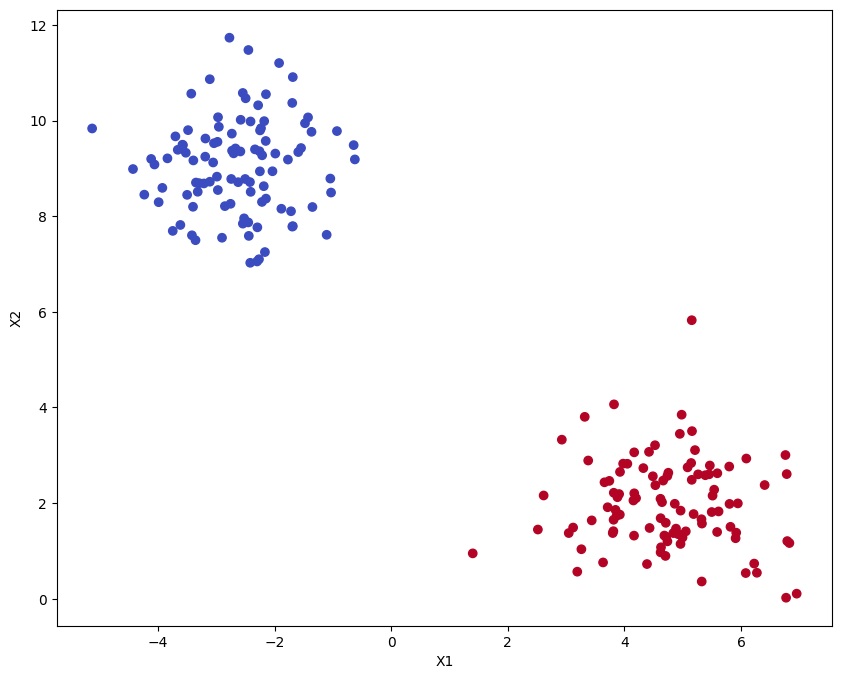

In [64]:
plt.figure(figsize = [10,8])

plt.scatter(x = X[:,0],y = X[:,1], c = labels_y, cmap = 'coolwarm')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Remember, that the SVM dual problem can be formulated as a Quadratic programming (QP) problem.
We will solve it using a QP solver from the `CVXOPT` library.

We use the following form of a QP problem:
$$
\text{minimize}_{\mathbf{x}}\quad
    \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} \\
\text{subject to}\quad
    \mathbf{G}\mathbf{x} \le \mathbf{h}\text{ and }
    \mathbf{A}\mathbf{x} = \mathbf{b}\, .

    -\mathbf{G}\mathbf{x} \le \mathbf{h} \implies \mathbf{G}\mathbf{x} \ge \mathbf{h}
$$

**Your task** is to formulate the SVM dual problems as a QP of this form and solve it using `CVXOPT`, i.e. specify the matrices $\mathbf{P}, \mathbf{G}, \mathbf{A}$ and vectors $\mathbf{q}, \mathbf{h}, \mathbf{b}$.

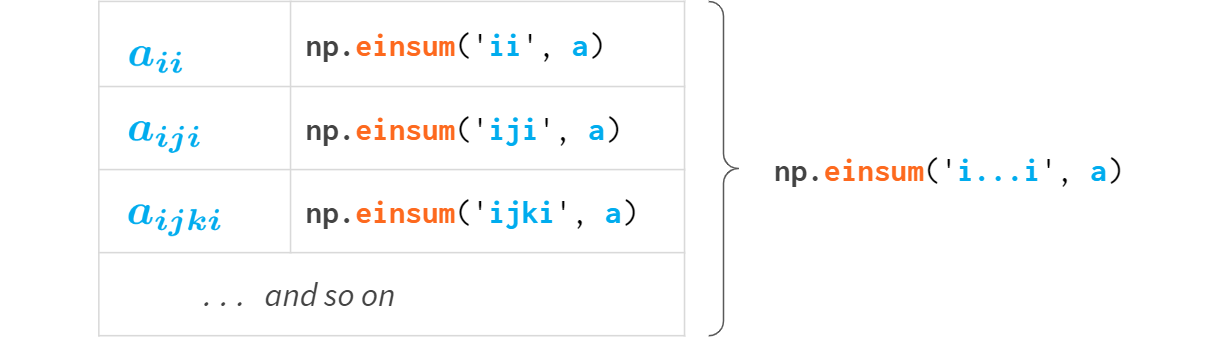
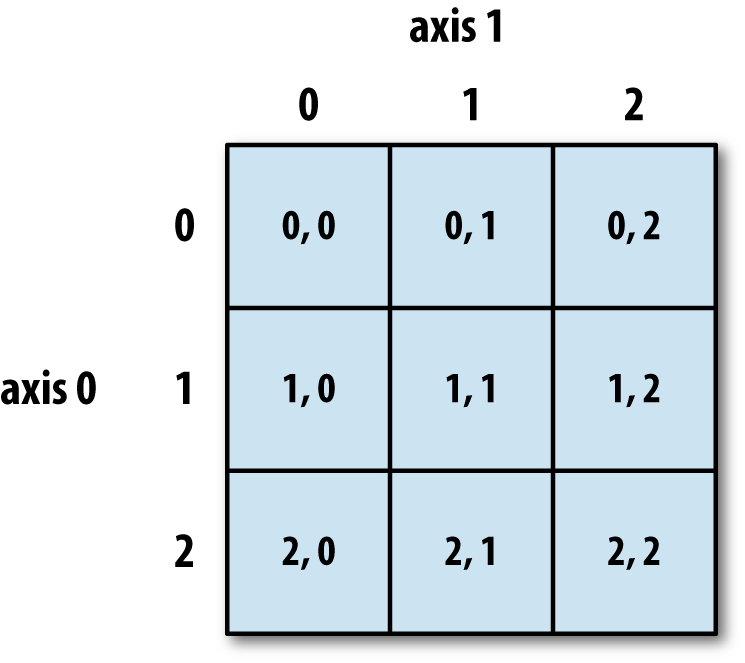

In [65]:
def solve_dual_svm(X,y):
    ## --- ## 

    ## -- ## 
    number_of_samples, number_of_features = X.shape #(  N , D )
    P = matrix(np.einsum("i,j,ik, jk -> ij", y, y, X, X))
    q = matrix(-np.ones([N,1]))

    ## inequality constaints 
    G = matrix(-np.eye(N))
    h = matrix(np.zeros(N))

    ## equality constraints 
    print(y, y.shape)

    A = matrix(y.reshape(1,-1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False

    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    print(alphas.shape)
    alph = alphas.reshape(-1)
    print("after reshape ", alph.shape)
    return alph 




In [46]:
def compute_weights_and_bias(alpha, X, y):

    w = np.einsum("i,i,ij -> j", alpha, y, X)
    ## 
    support_vecs = (alpha > 1e-4)
    biases = y[support_vecs] - np.dot(X[support_vecs, :], w)

    b = np.sum(alpha[support_vecs] * biases) / np.sum(alpha[support_vecs])
    return w, b 

In [48]:
alpha_tol = 1e-4
def plot_hyperplane_and_support_vecs(X, y, alpha, w, b):

    plt.figure(figsize=[10, 8])
    # Plot the hyperplane
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.linspace(X[:, 0].min(), X[:, 0].max())
    plt.plot(x, x * slope + intercept, 'k-', label='decision boundary')
    plt.plot(x, x * slope + intercept - 1/w[1], 'k--')
    plt.plot(x, x * slope + intercept + 1/w[1], 'k--')
    # Plot all the datapoints
    plt.scatter(X[:, 0], X[:, 1], c=y)
    # Mark the support vectors
    support_vecs = alpha > alpha_tol
    plt.scatter(X[support_vecs, 0], X[support_vecs, 1], c=y[support_vecs], s=250, marker='*', label='support vectors')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')
    plt.show()

[ 1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.
  1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.
 -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.
 -1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1.  1.
  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.
  1. -1.] (200,)
(200, 1)
after reshape  (200,)


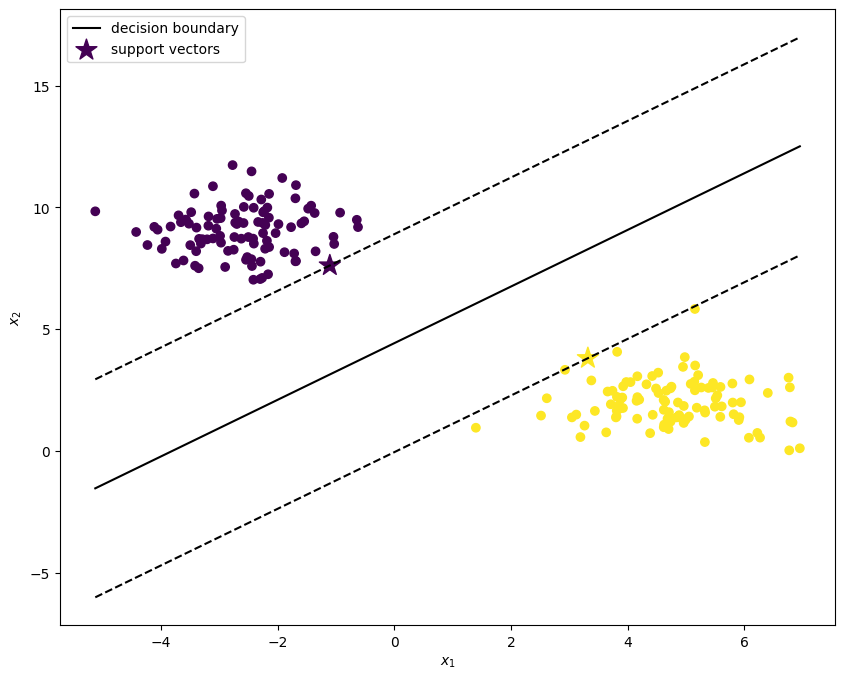

In [66]:
alpha = solve_dual_svm(X, labels_y)
w, b = compute_weights_and_bias(alpha, X, labels_y)
plot_hyperplane_and_support_vecs(X, labels_y, alpha, w, b)